In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc

In [2]:
adata = sc.read('sim_st_pred_2.h5ad')
adata

AnnData object with n_obs × n_vars = 1000 × 1000
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'sizeFactor', 'y', 'label', 'pred', 'pred_probability'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6'
    uns: 'log1p'
    obsm: 'spatial'
    obsp: 'adjacency_matrix'

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=300)

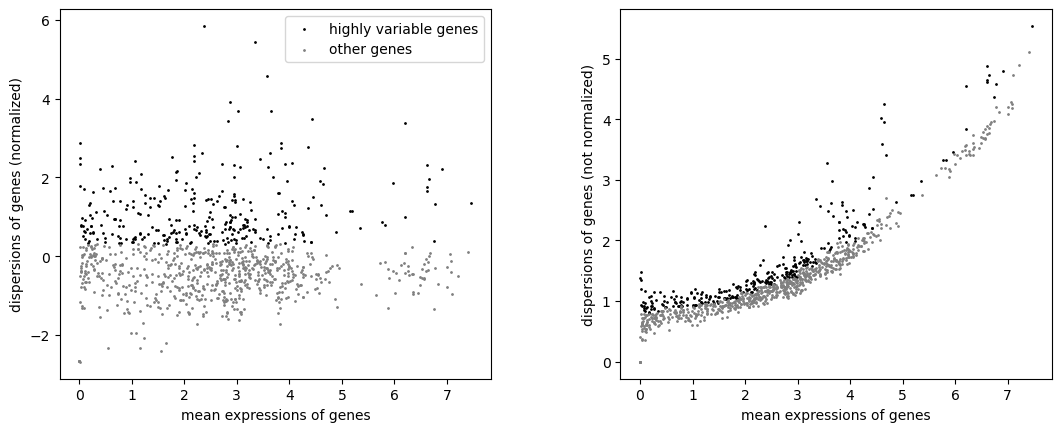

In [4]:
sc.pl.highly_variable_genes(adata)

In [5]:
sc.tl.pca(adata)

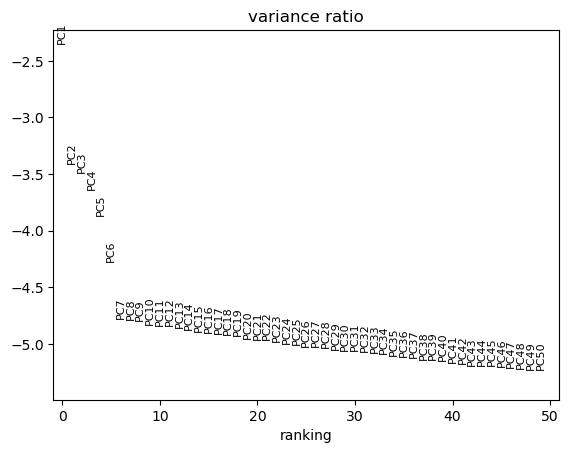

In [6]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [7]:
sc.pp.neighbors(adata)

In [8]:
sc.tl.umap(adata)

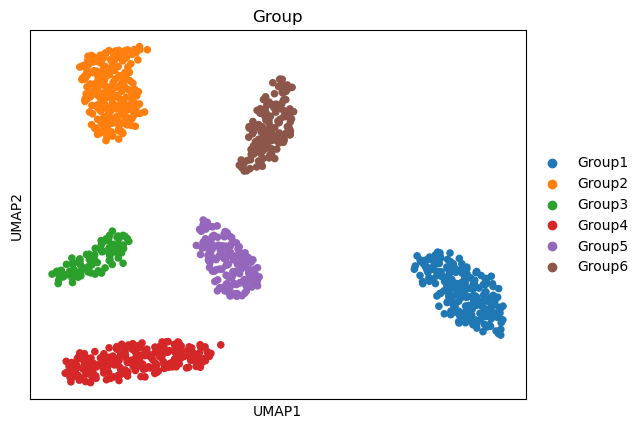

In [9]:
sc.pl.umap(
    adata,
    color="Group",
)

In [10]:
sc.tl.leiden(adata,resolution=0.5, key_added="leiden")

C:\Users\25922\AppData\Local\Temp\ipykernel_14680\4234346915.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata,resolution=0.5, key_added="leiden")


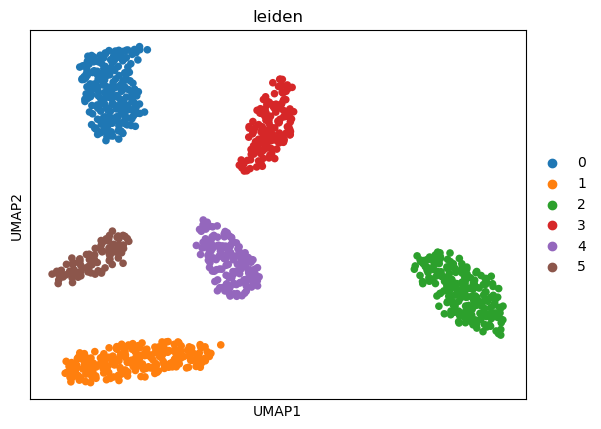

In [11]:
sc.pl.umap(adata, color=["leiden"])

In [12]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

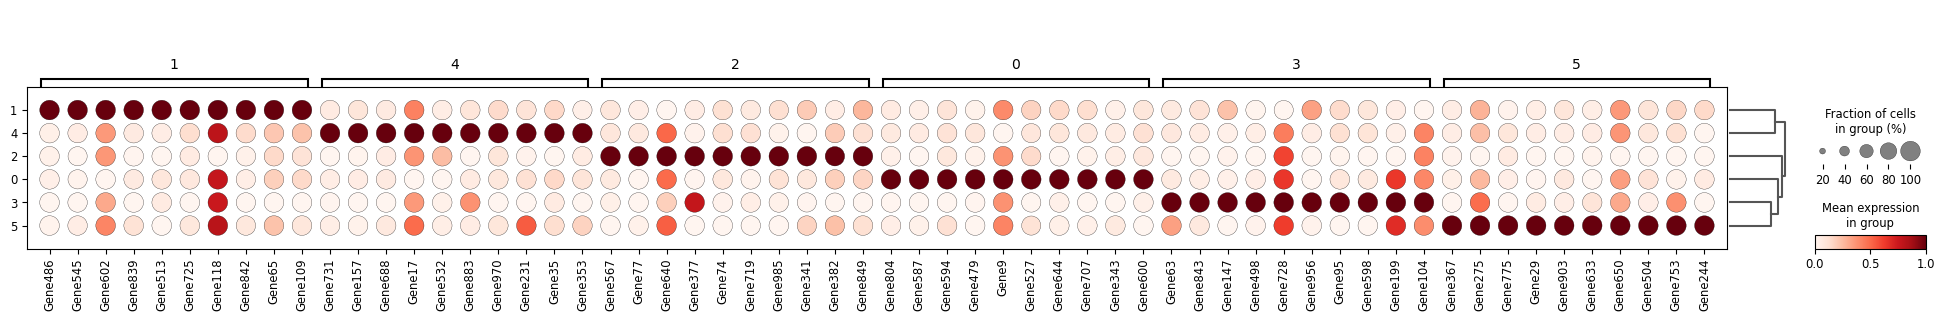

In [13]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=10
)

In [14]:
sc.get.rank_genes_groups_df(adata, group="0")[sc.get.rank_genes_groups_df(adata, group="0")['names']=='Gene804']

,names,scores,logfoldchanges,pvals,pvals_adj
0,Gene804,22.407497,1.868409,3.326158e-111,3.326158e-108


In [15]:
group_genes={}
group_genes['group2_wilcoxon']=sc.get.rank_genes_groups_df(adata, group="0")#[sc.get.rank_genes_groups_df(adata, group="0")['pvals_adj']<=0.05]
group_genes['group4_wilcoxon']=sc.get.rank_genes_groups_df(adata, group="1")#[sc.get.rank_genes_groups_df(adata, group="1")['pvals_adj']<=0.05]
group_genes['group1_wilcoxon']=sc.get.rank_genes_groups_df(adata, group="2")#[sc.get.rank_genes_groups_df(adata, group="2")['pvals_adj']<=0.05]
group_genes['group6_wilcoxon']=sc.get.rank_genes_groups_df(adata, group="3")#[sc.get.rank_genes_groups_df(adata, group="3")['pvals_adj']<=0.05]
group_genes['group5_wilcoxon']=sc.get.rank_genes_groups_df(adata, group="4")#[sc.get.rank_genes_groups_df(adata, group="4")['pvals_adj']<=0.05]
group_genes['group3_wilcoxon']=sc.get.rank_genes_groups_df(adata, group="5")#[sc.get.rank_genes_groups_df(adata, group="5")['pvals_adj']<=0.05]

In [16]:
for i in range(1,7):
    group_genes['group{}_wilcoxon'.format(i)]['score']=group_genes['group{}_wilcoxon'.format(i)]['pvals_adj'].apply(lambda x: -np.log10(x))
    group_genes['group{}_wilcoxon'.format(i)]['abs_logFC']=group_genes['group{}_wilcoxon'.format(i)]['logfoldchanges'].apply(lambda x: np.abs(x))

In [17]:
for i in range(1,7):
    df = pd.read_csv('group{}.csv'.format(i), sep=',',index_col=0)
    df['names'] = df['gene'].apply(lambda x: 'Gene' + str(x + 1))
    group_genes['group{}_graphSVX'.format(i)] = pd.merge(df, group_genes['group{}'.format(i)+'_wilcoxon'][['names','logfoldchanges']], on='names')
    group_genes['group{}_graphSVX'.format(i)]['abs_logFC']=group_genes['group{}_graphSVX'.format(i)]['logfoldchanges'].apply(lambda x: np.abs(x))

In [31]:
group_genes['group1_graphSVX'].head(10)

,gene,score,names,logfoldchanges,abs_logFC
0,117,0.130343,Gene118,-1.958864,1.958864
1,948,0.124037,Gene949,-1.200165,1.200165
2,566,0.120421,Gene567,1.453507,1.453507
3,76,0.105231,Gene77,1.678189,1.678189
4,168,0.092850,Gene169,-1.106539,1.106539
5,718,0.074739,Gene719,1.323109,1.323109
6,984,0.073901,Gene985,1.454079,1.454079
7,629,0.071822,Gene630,-1.016984,1.016984
8,381,0.070196,Gene382,0.958635,0.958635
9,187,0.064270,Gene188,-1.423658,1.423658


In [30]:
group_genes['group1_wilcoxon'].head(10)

,names,scores,logfoldchanges,pvals,pvals_adj,score,abs_logFC
0,Gene567,21.787668,1.453507,3.037211e-105,1.518606e-102,101.818555,1.453507
1,Gene77,21.235025,1.678189,4.534454e-100,1.511485e-97,96.820596,1.678189
2,Gene640,19.256184,0.825798,1.252797e-82,2.505594e-80,79.601089,0.825798
3,Gene377,18.361820,0.763546,2.655588e-75,4.425980e-73,72.353991,0.763546
4,Gene74,18.247643,0.979639,2.160329e-74,3.086185e-72,71.510578,0.979639
5,Gene719,17.993616,1.323109,2.186172e-72,2.732715e-70,69.563406,1.323109
6,Gene985,17.682838,1.454079,5.686058e-70,6.317842e-68,67.199431,1.454079
7,Gene341,13.176969,1.029633,1.190801e-39,9.160005e-38,37.038104,1.029633
8,Gene382,12.375568,0.958635,3.543785e-35,2.531275e-33,32.596661,0.958635
9,Gene849,11.549170,0.474255,7.453687e-31,4.384522e-29,28.358078,0.474255


In [20]:
clusters = adata.obs['leiden'].astype(int)
clusters

Cell1       1
Cell2       2
Cell3       5
Cell4       2
Cell5       2
           ..
Cell996     2
Cell997     2
Cell998     2
Cell999     2
Cell1000    0
Name: leiden, Length: 1000, dtype: int32

In [21]:
# def plot_single_roc(data, logFC_index, qval_index, kLog2Cutoff, color):
#     y_true = np.where(np.abs(data[logFC_index]) > kLog2Cutoff, 1, 0)
#     y_scores = data[qval_index]
    
#     # Compute ROC curve and ROC area
#     fpr, tpr, _ = roc_curve(y_true, y_scores)
#     roc_auc = auc(fpr, tpr)
    
#     # Plot ROC curve
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, color=color, lw=2, label=f'wilconx (AUC = {roc_auc:.3f})')
#     plt.plot([0, 1], [0, 1], 'k--', lw=2)
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve')
#     plt.legend(loc='lower right')
#     plt.show()

# # 调用绘图函数
# plot_single_roc(group_genes['group1'], 'logfoldchanges', 'pvals', 0.5, '#1F78B4')

In [22]:
# adata_o = sc.read('sim_st_pred.h5ad')
# sc.tl.pca(adata_o)
# sc.pp.neighbors(adata_o)
# sc.tl.umap(adata_o)
# sc.tl.leiden(adata_o,resolution=0.5, key_added="leiden")
# sc.tl.rank_genes_groups(adata_o, groupby="leiden", method="wilcoxon")
# data_o=sc.get.rank_genes_groups_df(adata_o, group="0")
# data_o['abs_logFC']=data_o['logfoldchanges'].apply(lambda x: np.abs(x))

graphSVX sum AUC: 4.570300771935473


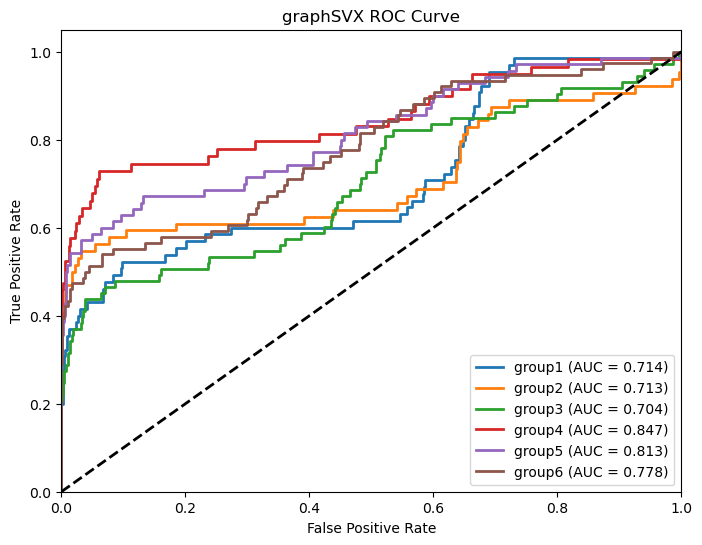

In [23]:
def plot_groups_roc(data, kLog2Cutoff,method):

    plt.figure(figsize=(8, 6))

    AUC = 0

    for i in range(1,7):
        y_true = np.where(np.abs(data['group{}_'.format(i)+method]['abs_logFC']) > kLog2Cutoff, 1, 0)
        y_scores = data['group{}_'.format(i)+method]['score']
    
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'group{i} (AUC = {roc_auc:.3f})')
        AUC += roc_auc
    
    print('graphSVX sum AUC: {}'.format(AUC))
        
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(method+' ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_groups_roc(group_genes, 0.5,'graphSVX')

graphSVX sum AUC: 4.163530554105575


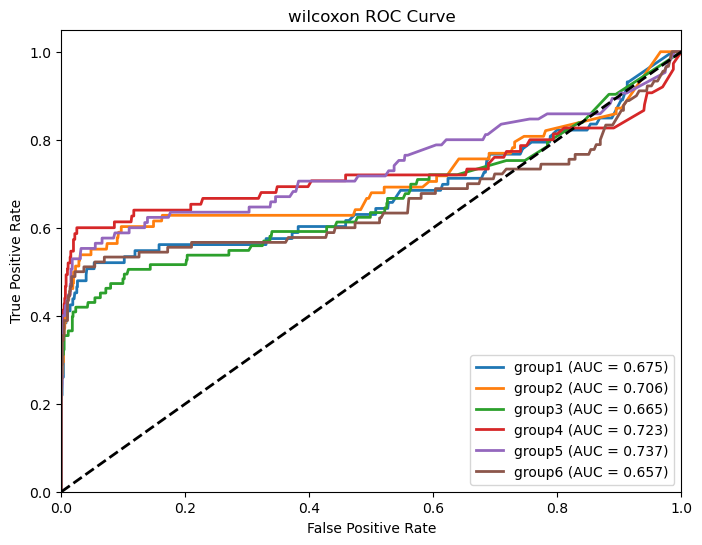

In [24]:
plot_groups_roc(group_genes, 0.5,'wilcoxon')

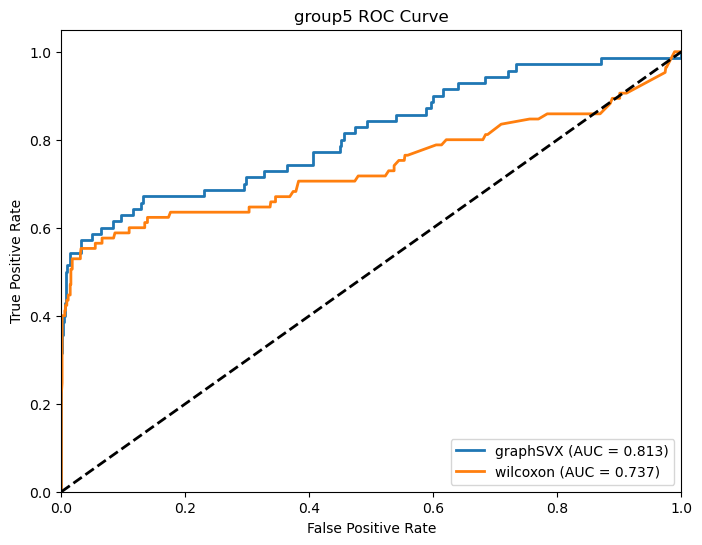

In [25]:
def plot_methods_roc(data, kLog2Cutoff, group):
    plt.figure(figsize=(8, 6))


    y_true = np.where(np.abs(data[group+'_graphSVX']['abs_logFC']) > kLog2Cutoff, 1, 0)
    y_scores = data[group+'_graphSVX']['score']

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'graphSVX (AUC = {roc_auc:.3f})')

    y_true = np.where(np.abs(data[group+'_wilcoxon']['abs_logFC']) > kLog2Cutoff, 1, 0)
    y_scores = data[group+'_wilcoxon']['score']

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'wilcoxon (AUC = {roc_auc:.3f})')
        
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(group+' ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_methods_roc(group_genes, 0.5,'group5')

In [26]:
sim = adata.copy()
sim.obsm['spatial'][:, 1] = -adata.obsm['spatial'][:, 1]

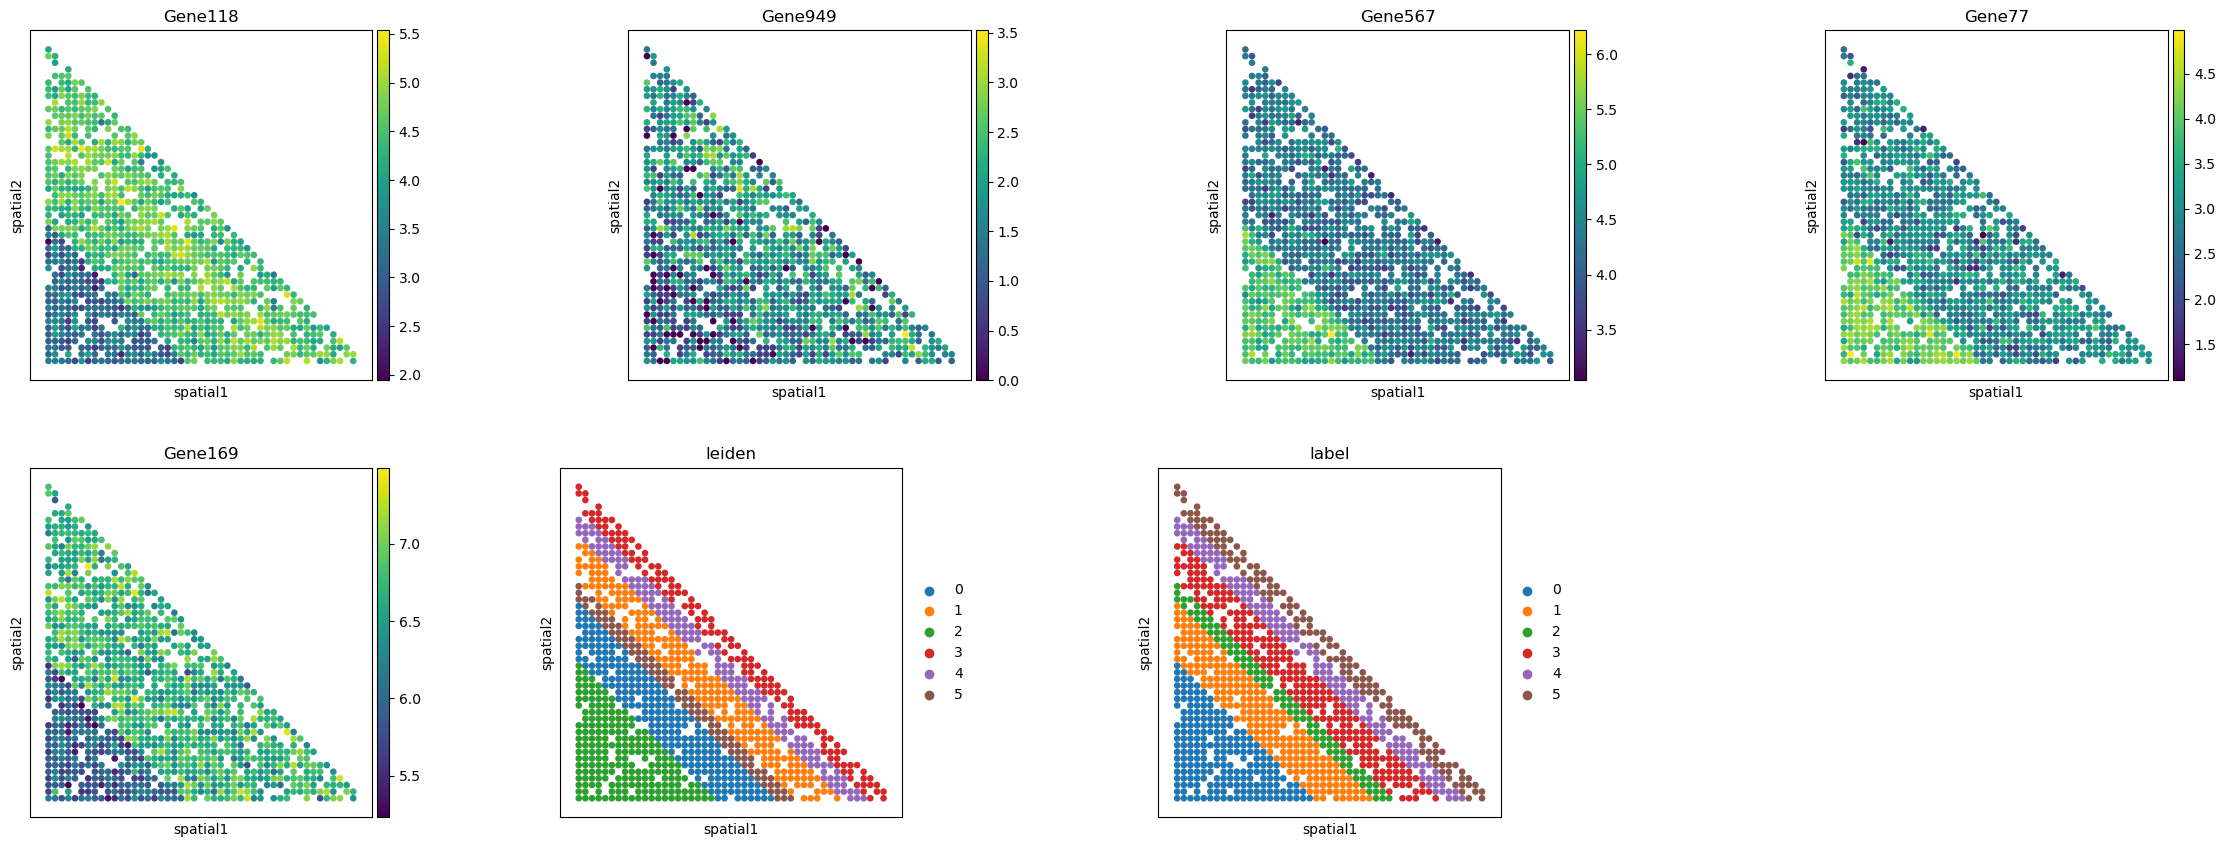

In [27]:
sim.obsm['spatial']
sc.pl.spatial(
    sim,
    color=['Gene118', 'Gene949', 'Gene567', 'Gene77', 'Gene169', 'leiden', 'label'],
    spot_size=1,
    # cmap='Reds'
)
plt.show()

In [28]:
sim.obs['y']

Cell1       3
Cell2       0
Cell3       2
Cell4       0
Cell5       0
           ..
Cell996     0
Cell997     0
Cell998     0
Cell999     0
Cell1000    1
Name: y, Length: 1000, dtype: int8

In [29]:
sim.obs['leiden']

Cell1       1
Cell2       2
Cell3       5
Cell4       2
Cell5       2
           ..
Cell996     2
Cell997     2
Cell998     2
Cell999     2
Cell1000    0
Name: leiden, Length: 1000, dtype: category
Categories (6, object): ['0', '1', '2', '3', '4', '5']